In [1]:
import matplotlib.pyplot as plt
import numpy as np
from graspy.simulations import sbm
from numpy.random import normal, poisson
from scipy.stats import norm
import random
import itertools
from math import exp as ex
from math import log
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
N = 300 #total nodes
k = 12 #community number
P = .25
dim = 2
totalSamplePerClass = 50

In [3]:
G1 = np.zeros((totalSamplePerClass,N,N))
G2 = np.zeros((totalSamplePerClass,N,N))

nodesPerCom = int(N/k)
n = [nodesPerCom]*k
activeNodes = [4,7]
differentiatingEdge = int(nodesPerCom**2*len(activeNodes)**2*P)
indx = []

for i in activeNodes:
    indx = np.append(indx,range((i-1)*nodesPerCom, i*nodesPerCom-1), axis = 0)
    
indx_ = list(itertools.product(indx,indx)) 
indx__ = random.sample(indx_, differentiatingEdge)


p = [[0.2]*k]*k
wt = [[normal]*k]*k
wtargs = []

for i in range(0,k):
    wtargs.append([])
    for j in range(0,k):
        if i!=j:
            wtargs[i].append({'loc': 0.1, 'scale': 0.18})
        else:
            wtargs[i].append({'loc': 0.3, 'scale': 0.18})

for k in range(0,totalSamplePerClass):
    G1[k,:,:] = sbm(n=n, p=p, wt=wt, wtargs=wtargs)

    G2[k,:,:] = sbm(n=n, p=p, wt=wt, wtargs=wtargs)
    DiffEdge = norm.rvs(size=len(indx__),loc=0.2,scale=0.18)
    for i in range(0,len(indx__)):
        G2[k,int(indx__[i][0]),int(indx__[i][1])] = DiffEdge[i]


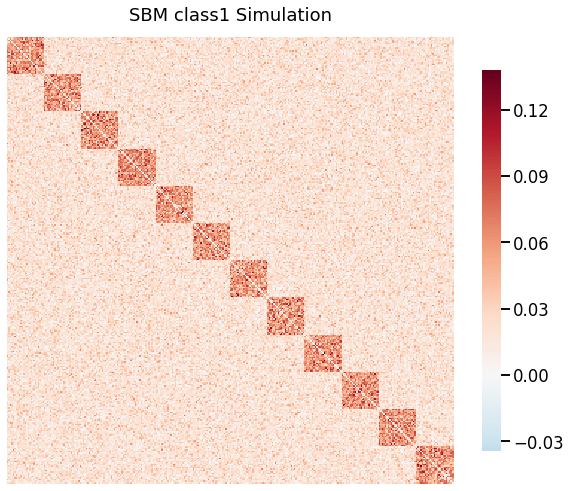

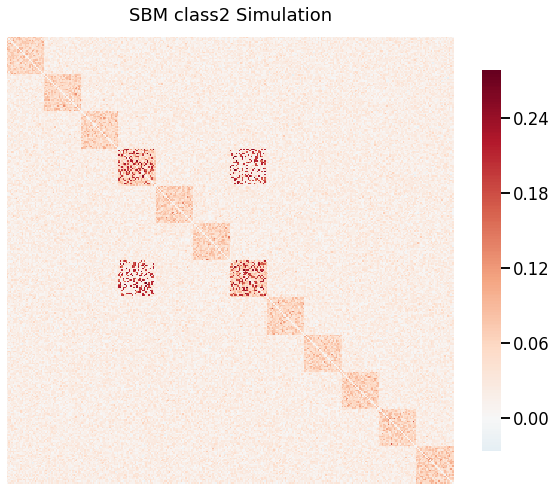

In [4]:
from graspy.plot import heatmap

heatmap(G1.mean(axis = 0), title ='SBM class1 Simulation')
heatmap(G2.mean(axis = 0), title ='SBM class2 Simulation')

In [56]:
## generate orthonormal vectors
labelVec1 = np.asarray(range(1,dim+1))
labelVec2 = labelVec1.copy()

while labelVec1@labelVec2.T == labelVec1@labelVec1.T:
    np.random.shuffle(labelVec2)

e1 = labelVec1/(labelVec1@labelVec1.T)**.5
e2 = labelVec2 - (labelVec2@labelVec1.T/(labelVec1@labelVec1.T))*labelVec1
e2 = e2/(e2@e2.T)**.5

In [57]:
y1 = np.asarray([0]*totalSamplePerClass)
y2 = np.asarray([1]*totalSamplePerClass)

e = np.asarray([e1,e2])
y = np.concatenate((y1[1:41], y2[1:41]), axis=0)
A = np.concatenate((G1[1:41,:,:], G2[1:41,:,:]), axis=0)
sampleTest,_,_ = A.shape

In [70]:
print(e)

[[ 0.4472136   0.89442719]
 [ 0.89442719 -0.4472136 ]]


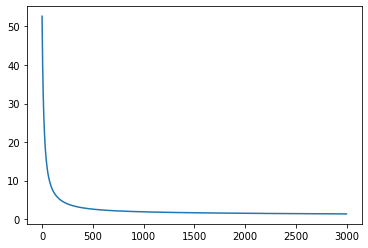

In [117]:
iter = 3000
a = 5e-3
B = np.ones((dim,N,N), dtype=float)/(dim*N*N)
b = 0
rho = 5e-4
gamma = 1e-6
ls = []

for itr in range(1,iter):
    loss = 0
    gradB = np.zeros((dim,N,N), dtype=float)
    sym = np.zeros((dim,N,N), dtype=float)
    gradb = 0
    for k in range(0,sampleTest):
        tmp = b
        tmpGradB = np.zeros((dim,N,N), dtype=float) 
        for i in range(0,dim):
            if y[k] == i:
                for j in range(0,dim):
                    tmp -= e[i,j]*np.sum(B[j,:,:]*A[k,:,:])
                    tmpGradB[j,:,:] -= e[i,j]*A[k,:,:]
            else:
                for j in range(0,dim):
                    tmp += e[i,j]*np.sum(B[j,:,:]*A[k,:,:])
                    tmpGradB[j,:,:] += e[i,j]*A[k,:,:]
        
        phi = ex(tmp)
        phi_ = phi/(1+phi)
        
        gradB += phi_*tmpGradB
        
    for i in range(0,dim):
        sym[i,:,:] = 2*(B[i,:,:]-B[i,:,:].T) 

    gradB = gradB/sampleTest + rho*np.sign(B) + 2*gamma*B + sym
    B = B - a*gradB
    
    for k in range(0,sampleTest):
        tmp = b 
        for i in range(0,dim):
            if y[k] == i:
                for j in range(0,dim):
                    tmp -= e[i,j]*np.sum(B[j,:,:]*A[k,:,:])
            else:
                for j in range(0,dim):
                    tmp += e[i,j]*np.sum(B[j,:,:]*A[k,:,:])
        
        phi = ex(tmp)
        
        loss += log(1+phi)
        gradb += phi/(1+phi)
        
    b = b - a*gradb/sampleTest
    #a = 1e-1/(itr)
    ls.append(loss)
    
plt.plot(ls)


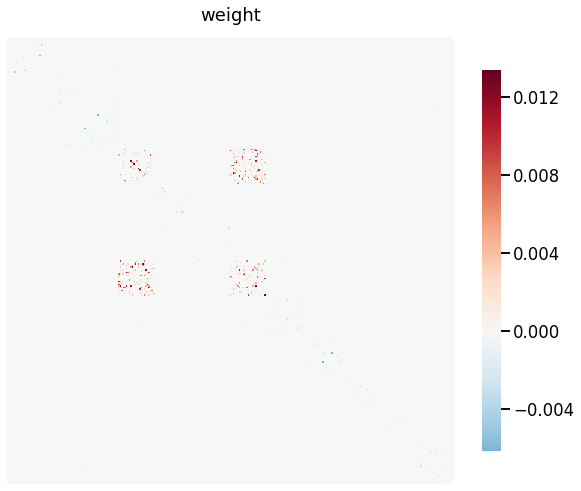

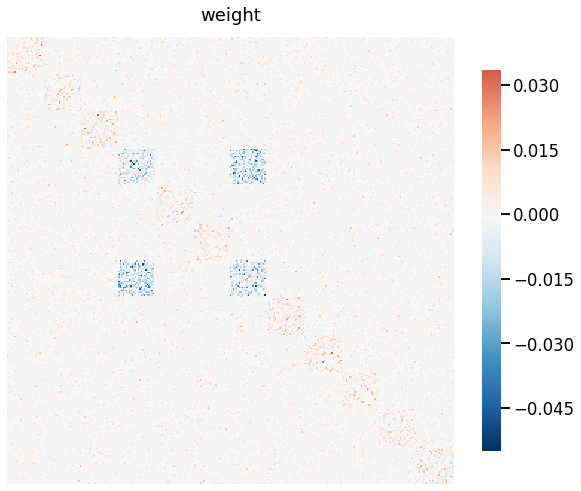

In [118]:
heatmap(B[0,:,:], title ='weight')
heatmap(B[1,:,:], title ='weight')

In [119]:
def predictAccuracy(B,b,e,A,y):
    l = len(y)
    dim,_,_ = B.shape
    accuracy = 0
    
    for i in range(0,l):
        lbl = []
        val = 0
        for j in range(0,dim):
            lbl.append(sum(e[j,k]*np.sum(B[k,:,:]*A[i,:,:]) for k in range(0,dim)))
            
        print(lbl)
        cls = np.argmax(np.asarray(lbl))
        #print(e@R@A[i,:,:]@C,y[i])
        #print('hi')
        print(cls, y[i])
        if cls == y[i]:
            accuracy += 1

    return accuracy*100/l

In [121]:
print(predictAccuracy(B,b,e,G2[40:50,:,:],y2[40:50]))

[-2.278159678021323, 1.4498259804371576]
1 1
[-0.8896626570247594, 0.7268212410799073]
1 1
[-0.9675161618259767, 0.7497675348145212]
1 1
[-0.7223573902343176, 0.6039287356535984]
1 1
[-0.8615531160911711, 0.7249035822110714]
1 1
[-1.0606119959317042, 0.7942548174322545]
1 1
[-1.0766901725602438, 0.8125207246041295]
1 1
[-0.648406958999432, 0.5399672507570448]
1 1
[-0.8556520039328416, 0.697409033208812]
1 1
[-1.1024945590567659, 0.8558968927172813]
1 1
100.0


In [114]:
b

-1.4273370573932525

In [49]:
e = np.asarray([[1,-1],[-1,1]])

In [82]:
tmp

710.4086994021668

In [123]:
print(B[0,1,200],B[0,200,1])

-1.3426019879289565e-07 -1.3426019879289565e-07
